# DETR para entrenar detección de imágenes

Antes de proceder a implementar el modelo hay que copiar el repositorio de DETR de Facebook ya que contiene implemetaciones necesarias para la arquitectura como su función de pérdida denonimada **Bipartite Matching loss**, en la que se asigna un bbox de verdad de terreno a un cuadro predicho usando un comparador tanto, cuando se realiza un ajuste fino, necesitamos el comparador (por ejemplo, **hungarian matcher** que se usa en el paper),también necesitamos la función **SetCriterion** que le da a la función de pérdida el backpropogation.

Por lo tanto utilizaremos git, para clonar el repositorio desde github a nuestro equipo utilizando la consola:
```{bash}
git clone https://github.com/facebookresearch/detr.git 
``` 

Para esta práctica se estará usando Jupyter notebook desde un entorno de Anaconda,  se utilizará pytorch y además, hay que instalar una libreria extra de pythorch llamada vision: https://github.com/pytorch/vision. Para instalarla en Anaconda hay que ejecutar en el Ananconda prompt: 
```{bash}
conda install torchvision -c pytorch 
``` 
Si no está instalado también habrá que instalar Pillow (PIL), pandas, OpenCV, Sklearn y Albumentations.

In [152]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm
from PIL import Image,ImageDraw
from matplotlib.pyplot import imshow

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision 

#sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split

#OpenCV
import cv2

#Glob
from glob import glob

In [2]:
#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Configuración básica para el modelo:

In [5]:
#n_folds = 5
seed = 42
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2

Para que los resultados sea replicables inicializamos todas las semillas:

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [7]:
seed_everything(seed)

### Preparación de datos:  
Los transformers usan los datos estructurados en formato **x, y, heigth y weigth**, los datos se han estructurado en otro jupyter notebook. Los datos de los bounding box están en un CSV llamado: "train_mouse_red_panda.csv" 

In [8]:
dataset = pd.read_csv('TransformerDataset/train/train_mouse_red_panda.csv')
dataset.head()

image_name           x           y       width      height  class
0  00165018e603855f.jpg  505.280000  363.691200  366.720000  212.580240  mouse
1  001d91060bb76e5e.jpg  524.399616  410.799900  912.799744  818.399400  mouse
2  001e1cf3abbee3cd.jpg  512.960000  287.072198  832.640000  512.628655  mouse
3  002c5a9026f5415c.jpg  499.520000  352.061912  188.800000  218.917892  mouse
4  003de0d25a90a01a.jpg  582.808576  336.810000  878.024704  630.020436  mouse

Internamente DETR trabajará con los datos normalizados para el tamaño de la imagen, por lo que el siguiente paso será normalizar los bounding box en un nuevo DataFrame.  

NOTA: Actualmente tenemos las imágenes de ambas categorias de datos en una carpeta juntas. 


In [9]:
dataset = dataset.rename(columns={'width':'width_bb', 'height':'height_bb'})
img_list = dataset["image_name"].unique()
path = r"TransformerDataset/data_images/"
for img in img_list:
    pil_img = Image.open(os.path.join(path,img))
    img_width, img_height = pil_img.size
    
    dataset.loc[lambda dataset: dataset['image_name'] == img, "x"] /= img_width #x_center
    dataset.loc[lambda dataset: dataset['image_name'] == img, "width_bb"] /= img_width #width_bb
    dataset.loc[lambda dataset: dataset['image_name'] == img, "y"] /= img_height #y_center
    dataset.loc[lambda dataset: dataset['image_name'] == img, "height_bb"] /= img_height #height_bb
    
dataset.head()

image_name         x         y  width_bb  height_bb  class
0  00165018e603855f.jpg  0.493437  0.534840  0.358125   0.312618  mouse
1  001d91060bb76e5e.jpg  0.512109  0.489047  0.891406   0.974285  mouse
2  001e1cf3abbee3cd.jpg  0.500938  0.419083  0.813125   0.748363  mouse
3  002c5a9026f5415c.jpg  0.487812  0.515464  0.184375   0.320524  mouse
4  003de0d25a90a01a.jpg  0.569149  0.515000  0.857446   0.963334  mouse

Hay que separar el conjunto de entrenamiento y de testeo por imagen, como ahora mismo tenemos un DataFrame donde están la clasificación por bounding box, necesitamos hacer el split por clasificación por imagen. Ya que sino al usar `train_test_split()` puede caer una misma imagen en train y test porque un bounding box cae en los dos conjuntos.   
NOTA: También se podrian separar los conjuntos de forma manual sin usar `train_test_split()` separándolos en carpetas. 

In [10]:
mouse_list = dataset["image_name"][dataset["class"] == "mouse"].unique()
red_panda_list = dataset["image_name"][dataset["class"] == "red_panda"].unique() 

image_list = np.concatenate((mouse_list, red_panda_list))
class_list = 300 * ["mouse"] + 300 * ["red_panda"]
len(class_list)

600

In [11]:
 x_train, x_test, y_train, y_test = train_test_split(image_list, class_list, #por defecto hace shuffle
                                                     test_size=0.1, random_state=seed,
                                                     stratify = class_list)

Ahora tenemos `x_train, x_test` que son las listas de imágenes para el conjunto de entrenamiento y test respectivamente.

In [12]:
len(x_train)

540

Pasar a codificación OneHotEncodding las dos clases que tenemos:  
mouse = 0   
red panda = 1  


In [13]:
dic_class = {"mouse":0,
            "red_panda":1
            }
dataset.replace({"class":dic_class},inplace=True)
dataset.head(2)

image_name         x         y  width_bb  height_bb  class
0  00165018e603855f.jpg  0.493437  0.534840  0.358125   0.312618      0
1  001d91060bb76e5e.jpg  0.512109  0.489047  0.891406   0.974285      0

Creamos una clase iteradora de Python llamada Dataset que se usa para poder añadir los datos al modelo usando DataLoader de Pytoch.

In [173]:
class Dataset(Dataset):
    def __init__(self,image_list, dataframe,transforms=None,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.images = image_list
        self.transforms = transforms
        self.dataframe = dataframe
        self.img_ids = {x:i for i,x in enumerate(image_list)} #diccionario de indexación interno a la clase
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self,index):
        image_name = self.images[index]
        record = self.dataframe[["x","y","width_bb","height_bb","class"]][self.dataframe["image_name"]==image_name]

        # Normalizamos las imágenes
        image = cv2.imread(os.path.join(path,image_name), cv2.IMREAD_COLOR) # OpenCV reads an image in BGR format 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) #Convert to RGB format
        #Albumentations uses the most common and popular RGB image format
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = record[["x","y","width_bb","height_bb"]].values
        labels =  record["class"].values

        #Para Data Augmentation
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, class_labels=labels)
            image  = transformed['image']
            boxes  = transformed['bboxes']
            labels = transformed['class_labels']
    
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        
        return image, target, image_name

In [174]:
#Prueba de class Dataset
data = Dataset(x_train, dataset)
npIMG, info, name = data[2]

Creamos las trasformaciones con **Albumentations** para el conjunto de train y redimensionamos las imágenes a un tamaño de 256 para reducir el tiempo de entrenamiento, además esta trasformación permite la conversión a tensores.  
Para que Albumentations realice las trasformaciones a los bounding box de acuerdo al redimensionado hay que indicarle el formato que siguen las coordenadas, para nuestro caso como ya se encuentran normalizadas ademas de ser la coordenada central y el tamaño del cuadrado correponden con el formato "yolo". Explicacion en la web de [Albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/).

In [22]:
def get_simple_transforms():
    transform = A.Compose([A.Resize(height=256, width=256, p=1.0), #redimensionamos a 256 por 256 
                      A.Normalize(max_pixel_value=1),
                      ToTensorV2(p=1.0) ], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
                    )
    return transform

In [23]:
def get_train_transforms():
    transform = A.Compose([
                        A.OneOf([A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit= 0.1, val_shift_limit=0.1, p=0.8),
                        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8)],p=0.8),
                        A.ToGray(p=0.01),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Resize(height=256, width=256, p=1.0), #redimensionamos a 512 por 512 
                        A.Normalize(max_pixel_value=1),
                        ToTensorV2(p=1.0)], 
                        p=1.0, 
                        bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
                       )
    return transform

Prueba de funcionamiento de la clase Dataset:

In [26]:
data_train = Dataset(x_train, dataset, transforms = get_simple_transforms())
data_test = Dataset(x_test, dataset, transforms = get_simple_transforms())

In [27]:
npIMG, info, name = data_train[2]
print(info)

{'boxes': tensor([[0.4336, 0.5156, 0.8291, 0.9469]]), 'labels': tensor([1]), 'image_id': tensor([2])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25 65 53 132
153 177 202 126
86 58 58 46
125 113 62 49


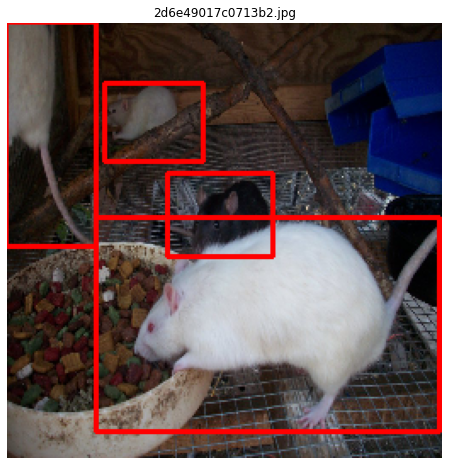

In [35]:
def show_example(image,target,image_id=None):
    np_image = image.cpu().numpy().transpose((1,2,0))
    # unnormalize the image
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    #np_image = (np_image*255).astype(np.uint8)
    target = {k: v.cpu().numpy() for k, v in target.items()} #Creo que esto va mal
    
    boxes = target['boxes']
    h,w,_ = np_image.shape
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    
    for box in boxes:
        print(box[0],box[1],box[2],box[3])
        xmin = int(box[0]-(box[2]/2))
        ymin = int(box[1]-(box[3]/2))
        xmax = int(box[2]+xmin)
        ymax = int(box[3]+ymin)
        cv2.rectangle(np_image, (xmin,ymin), (xmax, ymax), (255, 0, 0), 2)
        
    ax.set_axis_off()
    ax.imshow(np_image)
    #ax.imshow((np_image * 255).astype(np.uint8))
    ax.set_title(image_id)
    plt.show()
    
show_example(*data_train[3])

Comprobación que los bounding box están bien comparandolos con los almacenados en la clase Dataset.

[[0.1040625 0.26      0.208125  0.518334 ]
 [0.6028125 0.69875   0.789375  0.494166 ]
 [0.34      0.232917  0.23      0.1825   ]
 [0.4921875 0.4458335 0.245625  0.191667 ]]


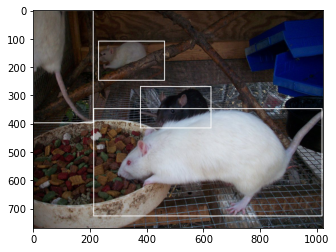

In [29]:
im = Image.open(os.path.join(path, x_train[3]))
array_xy_points = dataset[["x","y","width_bb","height_bb"]][dataset["image_name"]==x_train[3]].values
img_width, img_height = im.size
print(array_xy_points)

x = array_xy_points[:,0]*img_width
y = array_xy_points[:,1]*img_height
width_bb = array_xy_points[:,2]*img_width
height_bb = array_xy_points[:,3]*img_height

idraw = ImageDraw.Draw(im)

for i in range(len(array_xy_points)):
    xmin = (x[i] - width_bb[i]/2)
    ymin = (y[i] - height_bb[i]/2)
    xmax = xmin + (width_bb[i])
    ymax = ymin + (height_bb[i])
    idraw.rectangle((xmin, ymin, xmax, ymax), fill=None,width=3) #xmin, ymin, xmax, ymax

imshow(np.asarray(im))

## Modelo DETR

In [30]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [31]:
matcher = HungarianMatcher()
weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']

In [385]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [33]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

## Ejecución del modelo

In [35]:
def collate_fn(batch):
    return tuple(zip(*batch))

Creamos tres funciones, la primera para preparar el conjunto de entrenamiento y validación, la segunda para inicializar el modelo y la tercera para entrenarlo.   
En `trainModel()` se guardará durante la ejecución los mejores pesos para el conjunto de validación, para mantener esta comparativa funcional, en caso de que se vuelva a llamar la función para entrenar más tiempo el modelo, esta devolverá el mejor valor de la función loss almacenados para pasarse por parámetro en el caso de que volvamos a entrenar el modelo. 

In [64]:
def dataLoader():
    train_dataset = Dataset(x_train, dataset, transforms = get_train_transforms())
    valid_dataset = Dataset(x_test, dataset, transforms = get_simple_transforms())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, #DataLoader with multiple num_workers fails in Windows
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, #DataLoader with multiple num_workers fails in Windows
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader

def setUpModel():
    
    device = torch.device('cuda')
    
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    return model, criterion, optimizer


def trainModel(model, criterion, optimizer, train_data_loader, valid_data_loader, best_loss=10**5):
    
    device = torch.device('cuda')
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        train_losses_list.append(train_loss)
        valid_losses_list.append(valid_loss)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
            torch.save(model.state_dict(), f'detr_best_prueba3.pth')
    
    return best_loss

Comprobamos que tenemos cuda disponible para el entrenamiento:

In [146]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name('cuda'))

GeForce RTX 2060


In [61]:
#Procedimiento para entrenar el modelo:
BATCH_SIZE = 8
train_data_loader, valid_data_loader = dataLoader() #Cargamos los datos
model, criterion, optimizer = setUpModel() #Inicializamos el modelo, el optimizador y el criterio 

EPOCHS = 10
#Definimos una lista para visualizar los datos del entrenamiento
train_losses_list = []
valid_losses_list = []

#Le pasamos toddos los datos generados en las funcioness anteriores
best_loss = trainModel(model, criterion, optimizer, train_data_loader, valid_data_loader)

Using cache found in C:\Users\Usuario/.cache\torch\hub\facebookresearch_detr_master


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 0.609053827383939| VALID_LOSS 0.32519276812672615|
Best model found in Epoch 1........Saving Model


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 0.40247789989499483| VALID_LOSS 0.3104233145713806|
Best model found in Epoch 2........Saving Model


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.41429781979497743| VALID_LOSS 0.34872605092823505|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.4297072753748473| VALID_LOSS 0.33946916460990906|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.41417990011327405| VALID_LOSS 0.3984885402023792|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 0.39934147236978307| VALID_LOSS 0.3348010331392288|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 0.38290531889480706| VALID_LOSS 0.3364099785685539|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 0.3743417335345465| VALID_LOSS 0.3209826946258545|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 0.35898489570792985| VALID_LOSS 0.30238887667655945|
Best model found in Epoch 9........Saving Model


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 0.43124329276821194| VALID_LOSS 0.33189595863223076|


Entrenamos un poco más para ver si el modelo mejora.

In [62]:
EPOCHS = 30
best_loss = trainModel(model, criterion, optimizer, train_data_loader, valid_data_loader, best_loss=best_loss)

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 0.420610649182516| VALID_LOSS 0.39984259009361267|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 0.4211173934095046| VALID_LOSS 0.4060088284313679|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.39361031200079355| VALID_LOSS 0.3179503194987774|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.36031690086512| VALID_LOSS 0.32688153348863125|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.35524604316143427| VALID_LOSS 0.3049481250345707|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 0.35298724932705655| VALID_LOSS 0.3363572023808956|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 0.35951642735916023| VALID_LOSS 0.32120198756456375|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 0.39041438282412644| VALID_LOSS 0.33826457150280476|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 0.41141076429801826| VALID_LOSS 0.3886423707008362|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 0.40688269935986576| VALID_LOSS 0.35572975873947144|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 11| TRAIN_LOSS 0.38614536361659274| VALID_LOSS 0.31605569273233414|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 12| TRAIN_LOSS 0.35263363425345984| VALID_LOSS 0.31935745291411877|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 13| TRAIN_LOSS 0.36351437844774304| VALID_LOSS 0.30624003149569035|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 14| TRAIN_LOSS 0.4539163647329106| VALID_LOSS 0.4543296657502651|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 15| TRAIN_LOSS 0.5357071235775948| VALID_LOSS 0.3962335120886564|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 16| TRAIN_LOSS 0.38724371527924256| VALID_LOSS 0.3477563299238682|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 17| TRAIN_LOSS 0.3934239578597686| VALID_LOSS 0.302309587597847|
Best model found in Epoch 17........Saving Model


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 18| TRAIN_LOSS 0.3732721807763857| VALID_LOSS 0.29833830893039703|
Best model found in Epoch 18........Saving Model


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 19| TRAIN_LOSS 0.4209996906711775| VALID_LOSS 0.47186844795942307|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 20| TRAIN_LOSS 0.45056504230288896| VALID_LOSS 0.4479060582816601|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 21| TRAIN_LOSS 0.4481893896180041| VALID_LOSS 0.35210834816098213|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 22| TRAIN_LOSS 0.36934197759803605| VALID_LOSS 0.3038790840655565|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 23| TRAIN_LOSS 0.34303967063041296| VALID_LOSS 0.3094421215355396|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 24| TRAIN_LOSS 0.3409100915579235| VALID_LOSS 0.3205988258123398|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 25| TRAIN_LOSS 0.3607138857683715| VALID_LOSS 0.35371818765997887|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 26| TRAIN_LOSS 0.375224026687005| VALID_LOSS 0.31558106280863285|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 27| TRAIN_LOSS 0.3449408401022939| VALID_LOSS 0.3177406117320061|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 28| TRAIN_LOSS 0.34076744975412593| VALID_LOSS 0.33146725967526436|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 29| TRAIN_LOSS 0.3326949553892893| VALID_LOSS 0.31954615376889706|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 30| TRAIN_LOSS 0.3256247648421456| VALID_LOSS 0.2934296242892742|
Best model found in Epoch 30........Saving Model


In [43]:
EPOCHS = 50
best_loss = trainModel(model, criterion, optimizer, train_data_loader, valid_data_loader, best_loss=best_loss)

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 0.31836651156053825| VALID_LOSS 0.2627043891698122|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 0.30831920311731453| VALID_LOSS 0.2626374028623104|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.3129565650049378| VALID_LOSS 0.27643347904086113|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.3541569968356806| VALID_LOSS 0.30042185075581074|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.326069487587494| VALID_LOSS 0.30339227616786957|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 0.4602978799272986| VALID_LOSS 0.3718374893069267|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 0.36957905397695656| VALID_LOSS 0.33115672320127487|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 0.3430806271293584| VALID_LOSS 0.29498871602118015|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 0.34764768117490935| VALID_LOSS 0.3099392596632242|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 0.31778155135757785| VALID_LOSS 0.2856043428182602|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 11| TRAIN_LOSS 0.3188061821548378| VALID_LOSS 0.2955496422946453|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 12| TRAIN_LOSS 0.32971738015904145| VALID_LOSS 0.2997477147728205|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 13| TRAIN_LOSS 0.3113176154301447| VALID_LOSS 0.2709081191569567|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 14| TRAIN_LOSS 0.3047063379165004| VALID_LOSS 0.2709302846342325|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 15| TRAIN_LOSS 0.3577204988721539| VALID_LOSS 0.3473377451300621|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 16| TRAIN_LOSS 0.3645994060618036| VALID_LOSS 0.2935730330646038|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 17| TRAIN_LOSS 0.35002952112871055| VALID_LOSS 0.29394505731761456|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 18| TRAIN_LOSS 0.35265537701985417| VALID_LOSS 0.3141595907509327|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 19| TRAIN_LOSS 0.33733344297198686| VALID_LOSS 0.30268941447138786|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 20| TRAIN_LOSS 0.33302125992143855| VALID_LOSS 0.30401354655623436|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 21| TRAIN_LOSS 0.3337205328485545| VALID_LOSS 0.3337783068418503|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 22| TRAIN_LOSS 0.4010843496550532| VALID_LOSS 0.34423911944031715|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 23| TRAIN_LOSS 0.36774716833058524| VALID_LOSS 0.3454551473259926|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 24| TRAIN_LOSS 0.33656199188793406| VALID_LOSS 0.340429101139307|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 25| TRAIN_LOSS 0.3446115496404031| VALID_LOSS 0.32770751044154167|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 26| TRAIN_LOSS 0.33044470846652985| VALID_LOSS 0.3099622018635273|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 27| TRAIN_LOSS 0.3256934843957424| VALID_LOSS 0.31106263399124146|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 28| TRAIN_LOSS 0.3318125671323608| VALID_LOSS 0.3128470778465271|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 29| TRAIN_LOSS 0.33302105064777765| VALID_LOSS 0.3149838522076607|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 30| TRAIN_LOSS 0.35824088292086825| VALID_LOSS 0.32891471683979034|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 31| TRAIN_LOSS 0.37993165762985454| VALID_LOSS 0.37401691265404224|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 32| TRAIN_LOSS 0.43633391751962547| VALID_LOSS 0.41732557117938995|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 33| TRAIN_LOSS 0.4241238562938045| VALID_LOSS 0.326606884598732|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 34| TRAIN_LOSS 0.3379360638997134| VALID_LOSS 0.29419105127453804|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 35| TRAIN_LOSS 0.3534554687931257| VALID_LOSS 0.3050379753112793|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 36| TRAIN_LOSS 0.3345328107037965| VALID_LOSS 0.29799175448715687|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 37| TRAIN_LOSS 0.34992319455041604| VALID_LOSS 0.3162200506776571|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 38| TRAIN_LOSS 0.3989723447491141| VALID_LOSS 0.3730655126273632|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 39| TRAIN_LOSS 0.4959925421897103| VALID_LOSS 0.41283783689141273|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 40| TRAIN_LOSS 0.40045297978555455| VALID_LOSS 0.3456398621201515|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 41| TRAIN_LOSS 0.3720261555384187| VALID_LOSS 0.36636339873075485|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 42| TRAIN_LOSS 0.38341416944475737| VALID_LOSS 0.3370175361633301|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 43| TRAIN_LOSS 0.3710870137986015| VALID_LOSS 0.31478479132056236|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 44| TRAIN_LOSS 0.36018560476162853| VALID_LOSS 0.31623977050185204|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 45| TRAIN_LOSS 0.3529546495307894| VALID_LOSS 0.3225117102265358|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 46| TRAIN_LOSS 0.3274226197425057| VALID_LOSS 0.289925217628479|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 47| TRAIN_LOSS 0.33547088964020505| VALID_LOSS 0.2995449397712946|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 48| TRAIN_LOSS 0.462483225061613| VALID_LOSS 0.8786359205842018|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 49| TRAIN_LOSS 0.6725444386110586| VALID_LOSS 0.6312352195382118|


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

|EPOCH 50| TRAIN_LOSS 0.6421390758717761| VALID_LOSS 0.5329789072275162|


In [ ]:
plt.plot(train_losses_list, label='Training loss')
plt.plot(valid_losses_list, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Evaluar resultados

Preparamos los datos para proceder a visualizarlos, hay que tener en cuenta que la longitud del DataLoader se adaptará al tamaño de batch_size, es decir si el dataset tiene 1000 muestras y usamos un batch_size de 10, este tendrá una longitud de 100.   
Además, si queremos acceder a una imagen concreta para visualizarla tendremos que seleccionar el batch y el número de imagen dentro de ese batch.

In [66]:
valid_dataset = Dataset(x_test, dataset, transforms = get_simple_transforms())
     
valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, #DataLoader with multiple num_workers fails in Windows
        collate_fn=collate_fn
        )

print(len(valid_data_loader))

8


In [228]:
def view_sample(data_loader, model,device, nBatch = 0, intBatch=0): #Denimos la función para estimar y visualizar imágenes sueltasas
    
    dataiter = iter(data_loader)
    for i in range(0,nBatch+1):
        images, targets, image_ids = next(dataiter)
    
    _,h,w = images[intBatch].shape
    
    images = list(img.to(device) for img in images) #Obtenemos la lista de imágenes del Batch seleccionado
    
    #targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
        #         "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
        #                   objects in the target) containing the class labels
        #         "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
    
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    #print(targets[intBatch]['labels'])
    boxes = targets[intBatch]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    
    #Pasamos de GPU a la CPU el tensor
    sample = images[intBatch].permute(1,2,0).cpu().numpy() #Seleccionamos la imagen indicada con intBatch
    #sample = np.transpose(images[intBatch].cpu().detach().numpy(), (1, 2, 0))
    sample = sample*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406]) # unnormalize the image
    
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad(): #Indicamos al modelo que no aprenda
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        xmin = int(box[0]-(box[2]/2))
        ymin = int(box[1]-(box[3]/2))
        xmax = int(box[2]+xmin)
        ymax = int(box[3]+ymin)
        cv2.rectangle(sample, (xmin,ymin), (xmax, ymax), (255, 0, 0), 1)

      
    #outputs: This is a dict that contains at least these entries:
    #             "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
    #             "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
                    

    oboxes = outputs[0]['pred_boxes'][intBatch].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    
    #print(outputs[0]['pred_logits'][intBatch].softmax(1).detach().cpu().numpy())
    prob_out   = outputs[0]['pred_logits'][intBatch]
    prob = prob_out.softmax(1).detach().cpu().numpy()[:,0]*10
        
    for box,p in zip(oboxes,prob):
        #print("confianza= ",p," BB= ",box[0],box[1],box[2],box[3])
        if p >= 0.2: #: #si la confianza es inferior a un 20% no tenemos en cuenta la predicción
            color = (0,0,220) 
            xmin = int(box[0]-(box[2]/2))
            ymin = int(box[1]-(box[3]/2))
            xmax = int(box[2]+xmin)
            ymax = int(box[3]+ymin)
            cv2.rectangle(sample, (xmin,ymin), (xmax, ymax), color, 1) 
    
    ax.set_axis_off()
    ax.imshow(sample)

Para realizar las predicciones iniciaremos el modelo y cargaremos los pesos almacenados en el entrenamiento:  

Using cache found in C:\Users\Usuario/.cache\torch\hub\facebookresearch_detr_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


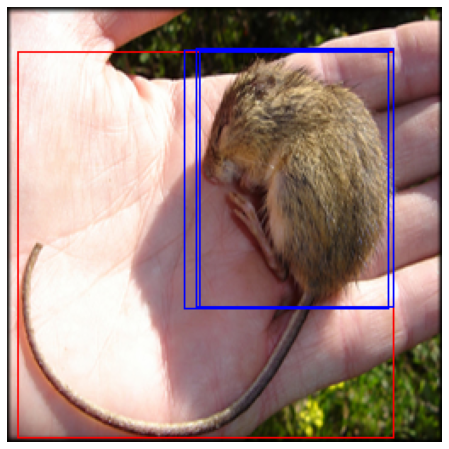

In [296]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_prueba3.pth"))

view_sample(valid_data_loader, model,torch.device('cuda'),nBatch=0, intBatch=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


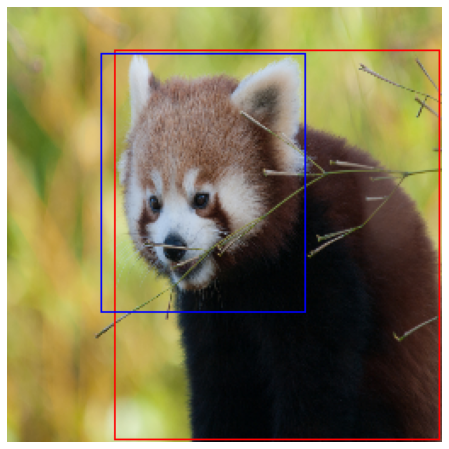

In [229]:
view_sample(valid_data_loader, model,torch.device('cuda'),nBatch=2, intBatch=1)

Visualizamos los resultados del modelo para la misma imagen del conjunto de train que visualizamos arriba.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


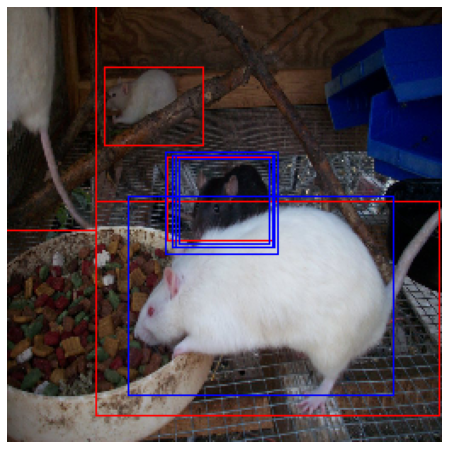

In [222]:
train_dataset = Dataset(x_train, dataset, transforms = get_simple_transforms())
     
train_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, #DataLoader with multiple num_workers fails in Windows
        collate_fn=collate_fn
        )

view_sample(train_data_loader, model,torch.device('cuda'),nBatch=0, intBatch=3)

### Limpieza de bounding box superpuestos
Como podemos observar se detectan varios bouding box superpuestos, por lo que cuando esten superpuestos nos quedaremos con el que tenga mejor confianza. Para ello usaremos la Non-maximum suppression (NMS) y tenemos que definir el IoU.
  
**Intersección sobre Unión**   
En el contexto de la determinación de la validez de una detección (máscara predicha), se necesita una métrica de apoyo denominada Intersección sobre Unión (también Índice Jaccard).

En los problemas de detección de objetos, IoU evalúa la superposición entre la máscara de verdad del terreno (**gt**) y la máscara predicha (**pd**). Se calcula como el área de intersección entre **gt** y **pd** dividida por el área de unión de los dos. La métrica de IoU oscila entre 0 y 1, donde 0 significa que no hay superposición y 1 implica una superposición perfecta.

<img src="esquemaIoU_esp.jpg" width="350">

Para ello nos ayudaremos de la librería `Polygon` que permite calcular tanto el área de un contorno como la intersección y unión de dos áreas. 



In [284]:
from shapely.geometry import Polygon

# xy_points = [xmin,ymin, xmax, ymax]
def calculate_first_bounding_box(xy_points):
    first_bb_points = [[int(xy_points[0]), int(xy_points[1])], 
                   [int(xy_points[2]), int(xy_points[1])], 
                   [int(xy_points[2]), int(xy_points[3])], 
                   [int(xy_points[0]), int(xy_points[3])]]
    
    return first_bb_points

def calculate_second_bounding_box(xy_points):
    second_bb_points  = [[int(xy_points[0]), int(xy_points[1])], 
                   [int(xy_points[2]), int(xy_points[1])], 
                   [int(xy_points[2]), int(xy_points[3])], 
                   [int(xy_points[0]), int(xy_points[3])]]
    
    return second_bb_points

def calculate_iou(points1, points2):
    poly_1 = Polygon(calculate_first_bounding_box(points1))
    poly_2 = Polygon(calculate_second_bounding_box(points2))
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:  
* "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth                    objects in the target) containing the class labels
* "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        

outputs: This is a dict that contains at least these entries:  
+ "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
+ "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates

In [287]:
def predict_batch(data_loader, model, device, nBatch = 0): #Denimos la función para estimar imágenes sueltas
    
    dataiter = iter(data_loader)
    for i in range(0,nBatch+1):
        images, targets, image_ids = next(dataiter)
    
    images = list(img.to(device) for img in images) #Obtenemos la lista de imágenes del Batch seleccionado    
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad(): #Indicamos al modelo que no aprenda
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    return images, targets, outputs
                    
def transform_bb(boxes):
    for box in boxes:
        box[0] = box[0]-(box[2]/2)
        box[1] = box[1]-(box[3]/2)
        box[2] = box[2]+box[0]
        box[3] = box[3]+box[1]
    return boxes
        
def extract_data(images, targets, outputs, intBatch=0):
    
    _,h,w = images[0].shape #_,h,w = images[intBatch].shape
    
    #Tratamiento de la ground truth
    boxes = targets[intBatch]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    boxes = transform_bb(boxes) #Adaptamos las coordenadas de los bb a xmin,ymin,xmax,ymax
    
    #Pasamos de GPU a la CPU el tensor
    sample = images[intBatch].permute(1,2,0).cpu().numpy() #Seleccionamos la imagen indicada con intBatch
    sample = sample*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406]) # unnormalize the image
       
    #Predicted bb
    oboxes = outputs[0]['pred_boxes'][intBatch].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    oboxes = transform_bb(oboxes) #Adaptamos las coordenadas de los bb a xmin,ymin,xmax,ymax 
    
    #Predicted prob
    prob_out   = outputs[0]['pred_logits'][intBatch]
    prob = prob_out.softmax(1).detach().cpu().numpy()[:,0]*10
    

    return  sample, boxes, oboxes, prob
       

Definimos nuestro propio método para reducir el solapamiento de los bounding boxes, descartando primero aquellos que no tengan una confianza superior a un 20% y luego calculando el IoU para el solapamiento, elminando así aquellos recuadros que tengan IoU altos.

In [355]:
def NMS (p_boxes, prob, umbral_IoU = 0.5):
    
    pred_list = sorted(zip(p_boxes,prob) , key=lambda x: x[1], reverse=True)
    pred_list = list(filter(lambda x: x[1] > 0.2, pred_list)) #Solo aquellos valores con una confianza de un 20%
    counter = 0
    
    while counter < len(pred_list):
        comparator = pred_list[counter]

        #Calculamos todos los IoU de cada elemento para el resto
        IoU_list = []
        for i in range(counter+1, len(pred_list)):
            IoU_list.append(calculate_iou(comparator[0], pred_list[i][0]))    

        index_list = range(counter+1, len(pred_list))
        descartes = [index for iou,index in zip(IoU_list,index_list) if iou >= umbral_IoU]
        descartes.reverse()
        for index in descartes:
            pred_list.pop(index)

        counter = counter + 1

    return pred_list

Medir el rendimiento de un detector de objetos implica determinar si una detección es válida o no. Así pues se procederá a calcular el número de verdaderos positivos, falsos positivos y falsos negativos que detecta el modelo.  
+ Verdadero positivo (TP): una detección válida.
+ Falso positivo (FP): detección no válida.
+ Falso negativo (FN): el modelo no detecta la verdad sobre el terreno.
+ Verdadero negativo (TN): esta métrica no se aplica en la detección de objetos porque hay infinitas instancias que no deben detectarse como objetos.

Con la métrica de IoU, necesitamos definir un umbral (α, digamos) que se utiliza para distinguir una detección válida de la que no lo es.
Por lo tanto, podemos redefinir **TP** (detección correcta) como una detección para la cual IoU≥ α y **FP** (detección no válida) con IoU <α. **FN** es una verdad fundamental que el modelo ha pasado por alto.


La **precisión** es la capacidad de un clasificador para identificar solo objetos relevantes. Es la proporción de detecciones positivas verdaderas.  
P = TP/ TP+FP = TP/ all detection

**Recordar** (recall) , por otro lado, mide la capacidad del modelo para encontrar todos los casos relevantes (es decir, todas las verdades fundamentales): la proporción de verdaderos positivos detectados entre todas las verdades fundamentales.  
R= TP/ TP+ FN = TP/ all ground-truths

In [356]:
def eval_modelo(valid_data_loader,model, alpha = 0.51):
    
    TP = 0 #Verdadero positivo (TP): una detección válida.
    FP = 0 #Falso positivo (FP): detección no válida.
    FN = 0 #Falso negativo (FN): el modelo no detecta la verdad sobre el terreno.
    des = 0 #Descartes
    #alpha = 0.59 #Umbral de IoU
    #confUmbral  = 0.40 #Umbral de confianza
    
    #Recorremos cada una
    
    for batch in range(BATCH_SIZE-1):  
        images, targets, outputs = predict_batch(valid_data_loader, model, torch.device('cuda'),nBatch=batch)
        #print("Batch = ", batch)
        for index in range(len(valid_data_loader)):
            #print("\t batch index= ", index)
            image, gt_boxes, p_boxes, prob =  extract_data(images, targets, outputs, intBatch=index)
            p_boxes_filtered = NMS(p_boxes, prob)
            
            predict_used = [] #Valores de predicciones usados
            #Si no hay predicciones son todo False Negative
            if(len(p_boxes_filtered)==0):
                FN = FN + len(gt_boxes) #Todo verdades no detectada
                continue
                
            for row_xy in gt_boxes: #Recorremos las verdades
                iou_array = []
                #Para cada verdad calcularemos los IoU con todas las predicciones
                for index,row_predict in enumerate(p_boxes_filtered): 
                    
                    if (index in predict_used): 
                        iou_array.append(0) #Aunque no se tenga en cuenta tenemos que mantener su posición
                    else:
                        iou_score = calculate_iou(row_xy, row_predict[0])
                        iou_array.append(iou_score)
                        
                #Si ninguno de los calculados por pares supera el umbral, no se ha detectado esa verdad
                if (max(iou_array) < alpha): FN = FN + 1
                else: #Tenemos una detección buena
                    TP = TP+1
                    n = np.argmax(iou_array)
                    predict_used.append(n)
                    
            FP = FP + (len(p_boxes_filtered) - len(predict_used))
        
    #print("(TP,FP,FN)-> ",TP,FP,FN,des) #(TP,FP,FN)->  361 137 140
    return TP,FP,FN

In [357]:
valid_dataset = Dataset(x_test, dataset, transforms = get_simple_transforms())
print(len(x_test)) 
valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, #DataLoader with multiple num_workers fails in Windows
        collate_fn=collate_fn
        )


TP,FP,FN = eval_modelo(valid_data_loader, model,alpha = 0.51)
print("(TP,FP,FN)-> ",TP,FP,FN)

60
(TP,FP,FN)->  36 55 36


In [358]:
#Calculamos los valores cuando solo hay una torre en el ground truths
P = TP/(TP+FP)
R = TP/(TP+FN)
#Manualmente he contado 91 FN
print("TP+FN = nº detecciones originales-> ", TP+FN)
print("Precisión: ", P)
print("Recall: ", R)

TP+FN = nº detecciones originales->  72
Precisión:  0.3956043956043956
Recall:  0.5


Estos resultados se deben a que los bounding box originales son bastante más grandes que los que detecta la red, ya que en el caso de los ratones no capta la cola y en el caso de los pandas rojos solo detecta la cara no todo el cuerpo debido a que la mayoría de imágenes del dataset de entrenamiento son de la cara de los pandas rojos. 

## Visualización de detecciones

Por último visualizarmeos algunos resultados ya filtrados de los datos.

In [378]:
def print_bb (sample,boxes,oboxes):
    
    for box in boxes:
        cv2.rectangle(sample, (box[0],box[1]), (box[2], box[3]), (255, 0, 0), 1)
    
    if oboxes: 
        p_oboxes = np.array(oboxes)[:,0]
        for box in p_oboxes:
            color = (0,0,220) 
            cv2.rectangle(sample,  (box[0],box[1]), (box[2], box[3]), color, 1) 

# Mostramos ejemplos de imágenes de 3 en 3     
def show_images(valid_data_loader, model, list_batch, list_index, n=3):
    
    fig, ax = plt.subplots(1, 3, figsize=(21, 8))
    for i in range(0,n):
        images, targets, outputs = predict_batch(valid_data_loader, model,torch.device('cuda'),nBatch=list_batch[i])
        image, gt_boxes, p_boxes, prob =  extract_data(images, targets, outputs, intBatch=list_index[i])
        p_boxes_filtered = NMS(p_boxes, prob)
        
        print_bb(image,gt_boxes,p_boxes_filtered)
        ax[i].set_axis_off()
        ax[i].imshow(image)

In [373]:
valid_dataset = Dataset(x_test, dataset, transforms = get_simple_transforms())
valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0, #DataLoader with multiple num_workers fails in Windows
        collate_fn=collate_fn
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


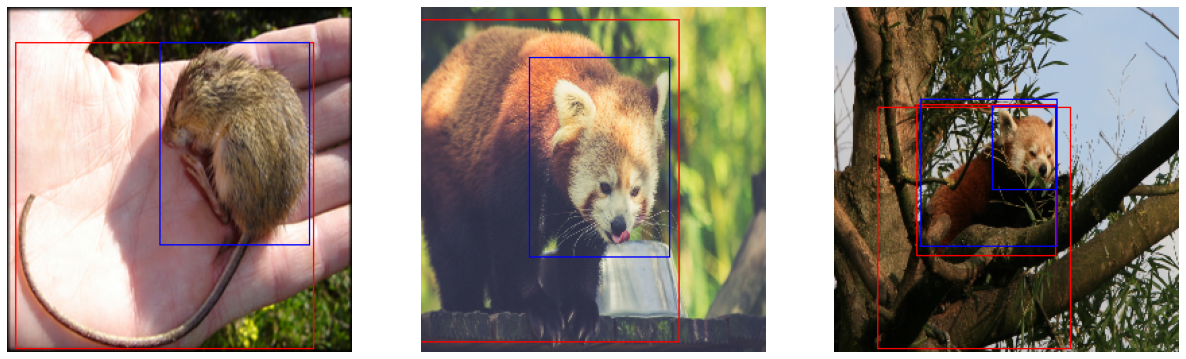

In [379]:
show_images(valid_data_loader, model, [0,0,1], [0,2,4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


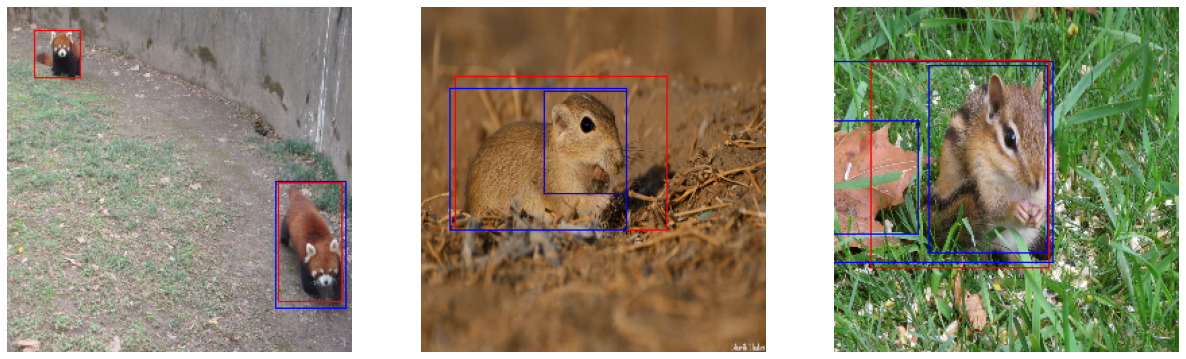

In [380]:
show_images(valid_data_loader, model, [1,2,3], [6,5,4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


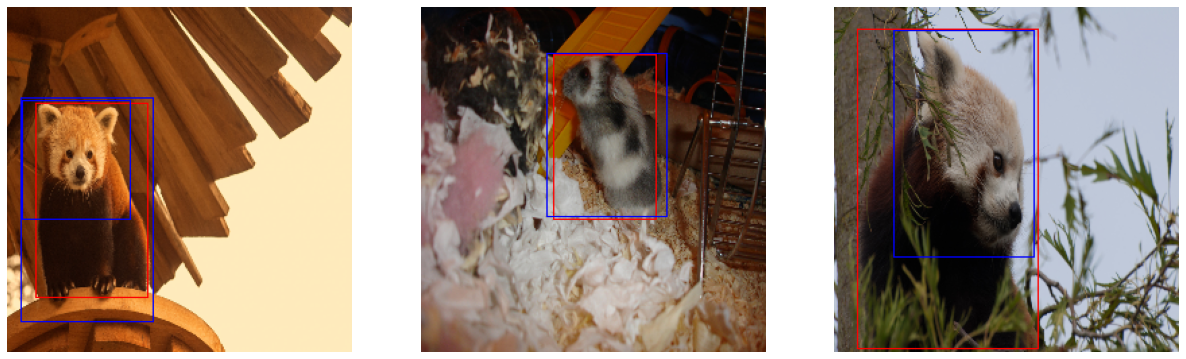

In [384]:
show_images(valid_data_loader, model, [4,5,6], [3,0,5])